<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Computer-Vision-Projects/blob/main/Image_classification_on_Stanford_Dogs_Dataset_via_fine_tuning_with_EfficientNet_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification on Stanford Dogs Dataset via fine-tuning with EfficientNet using Tensorflow Keras

**Author:** [Ashaduzzaman Sarker](www.linkedin.com/in/ashaduzzaman-sarker-piash)<br>
**Date created:** 2024/06/16<br>

## Setup

In [14]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

from keras import layers
from keras.applications import EfficientNetB0

In [15]:
# IMG_SIZE is determined by EfficientNetB0 model choice
IMG_SIZE = 224
BATCH_SIZE = 64

## Loading data

 Also applicable for datasets in TFDS such as - cifar10, cifar100, food101

In [16]:
dataset_name = 'stanford_dogs'

(ds_train, ds_test), ds_info = tfds.load(dataset_name,
                                         split=['train','test'],
                                         with_info=True,
                                         as_supervised=True)

NUM_CLASSES = ds_info.features['label'].num_classes

In [17]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

## Visualizing the data

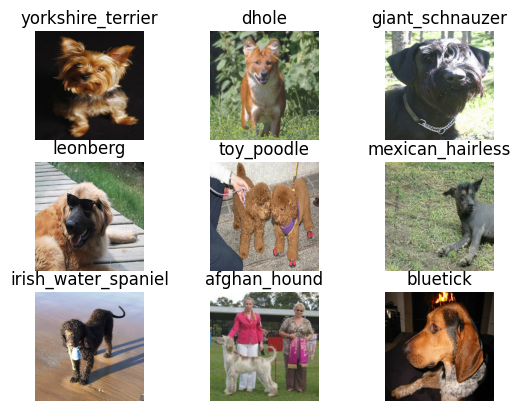

In [18]:
def format_label(label):
  string_label = label_info.int2str(label)
  return string_label.split('-')[1]

label_info = ds_info.features['label']
for i, (image, label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image.numpy().astype('uint8'))
  plt.title('{}'.format(format_label(label)))
  plt.axis('off')

## Data augmentation

In [19]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

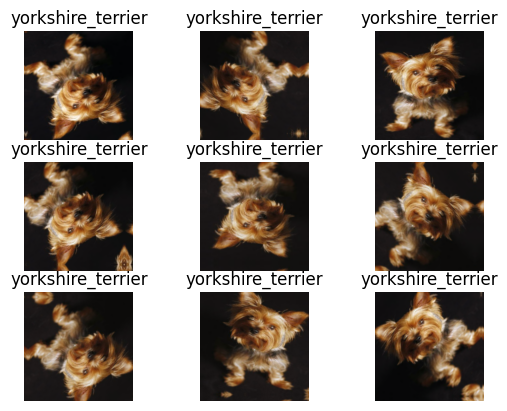

In [20]:
# Visualize the augmented images
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

## Prepare inputs for Model

In [21]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
  image = img_augmentation(image)
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

def input_preprocess_test(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Training a EfficientNetB0 model from scratch

In [22]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization_1

In [23]:
epochs = 40 # @param {type: "slider", min:10, max:100}

history = model.fit(ds_train,
                    epochs=epochs,
                    validation_data=ds_test)

Epoch 1/40
187/187 [==============================] - 72s 189ms/step - loss: 4.9520 - accuracy: 0.0118 - val_loss: 4.9120 - val_accuracy: 0.0140
Epoch 2/40
187/187 [==============================] - 34s 183ms/step - loss: 4.6717 - accuracy: 0.0166 - val_loss: 4.8789 - val_accuracy: 0.0106
Epoch 3/40
187/187 [==============================] - 34s 182ms/step - loss: 4.5226 - accuracy: 0.0264 - val_loss: 4.7344 - val_accuracy: 0.0250
Epoch 4/40
187/187 [==============================] - 34s 182ms/step - loss: 4.4152 - accuracy: 0.0331 - val_loss: 4.9992 - val_accuracy: 0.0264
Epoch 5/40
187/187 [==============================] - 34s 182ms/step - loss: 4.3272 - accuracy: 0.0420 - val_loss: 4.5579 - val_accuracy: 0.0318
Epoch 6/40
187/187 [==============================] - 34s 182ms/step - loss: 4.2322 - accuracy: 0.0508 - val_loss: 4.4263 - val_accuracy: 0.0503
Epoch 7/40
187/187 [==============================] - 34s 182ms/step - loss: 4.1386 - accuracy: 0.0600 - val_loss: 4.4199 - val_ac

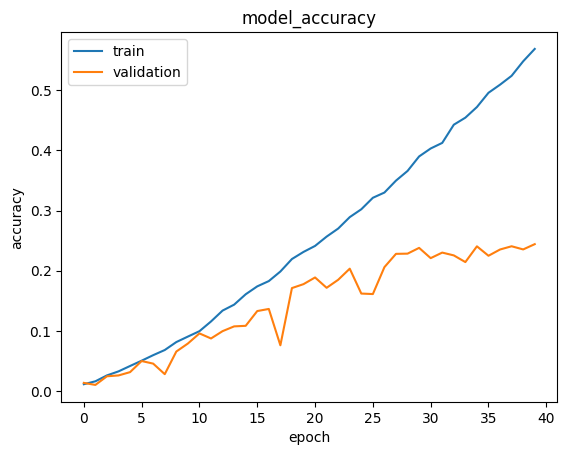

In [24]:
# Plotting the training and validation accuracy
import matplotlib.pyplot as plt

def plot_hist(hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

plot_hist(history)

## Transfer learning from pre-trained ImageNet weights

In [29]:
def build_model(num_classes):
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  model = EfficientNetB0(include_top=False,
                         input_tensor=inputs,
                         weights='imagenet')
  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
  outputs = layers.Dense(num_classes, activation='softmax', name='pred')(x)

  # Compile Model
  model = keras.Model(inputs, outputs, name='EfficientNet')
  optimizer = keras.optimizers.Adam(learning_rate=1e-2)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/25
187/187 [==============================] - 31s 131ms/step - loss: 3.2721 - accuracy: 0.4158 - val_loss: 0.8577 - val_accuracy: 0.7414
Epoch 2/25
187/187 [==============================] - 23s 121ms/step - loss: 1.6639 - accuracy: 0.5830 - val_loss: 0.6888 - val_accuracy: 0.7868
Epoch 3/25
187/187 [==============================] - 22s 120ms/step - loss: 1.3398 - accuracy: 0.6278 - val_loss: 0.6833 - val_accuracy: 0.7916
Epoch 4/25
187/187 [==============================] - 22s 120ms/step - loss: 1.2341 - accuracy: 0.6488 - val_loss: 0.6618 - val_accuracy: 0.7997
Epoch 5/25
187/187 [==============================] - 23s 121ms/step - loss: 1.1995 - accuracy: 0.6533 - val_loss: 0.6991 - val_accuracy: 0.7874
Epoch 6/25
187/187 [==============================] - 23s 121ms/step - loss: 1.1439 - accuracy: 0.6684 - val_loss: 0.6855 - val_accuracy: 0.7924
Epoch 7/25
187/187 [==============================] - 22s 120ms/s

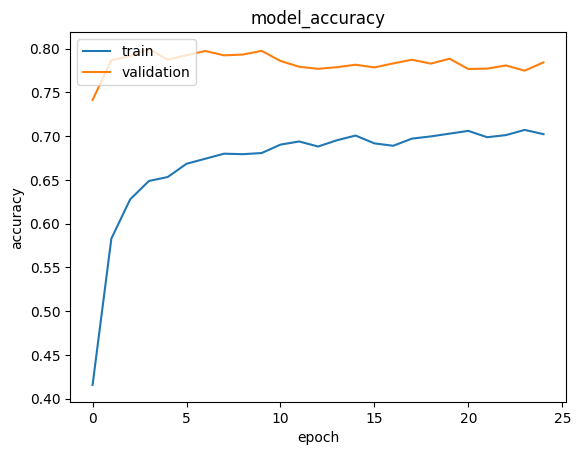

In [30]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 25 # @param {type: "slider", min:8, max:80}
history = model.fit(ds_train,
                 epochs=epochs,
                 validation_data=ds_test)
plot_hist(history)

## Fine-tuning EfficientNetB0 Model

> Freezing/unfreezing models: setting **trainable** of a Model will simultaneously set all layers belonging to the Model to the same trainable attribute. Each layer is trainable only if both the layer itself and the model containing it are trainable. Hence when we need to partially freeze/unfreeze a model, we need to make sure the trainable attribute of the model is set to **True**.

In [31]:
def unfreeze_model(model):
  # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
  # On unfreezing layers: The BatchNormalization layers need to be kept frozen
  for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  optimizer = keras.optimizers.Adam(learning_rate=1e-5)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

unfreeze_model(model)

In [32]:
epochs = 5  # @param {type: "slider", min:4, max:10}
history = model.fit(ds_train,
                 epochs=epochs,
                 validation_data=ds_test)

Epoch 1/5
187/187 [==============================] - 31s 128ms/step - loss: 0.9356 - accuracy: 0.7359 - val_loss: 0.7673 - val_accuracy: 0.7973
Epoch 2/5
187/187 [==============================] - 23s 121ms/step - loss: 0.8584 - accuracy: 0.7524 - val_loss: 0.7345 - val_accuracy: 0.8036
Epoch 3/5
187/187 [==============================] - 23s 122ms/step - loss: 0.8291 - accuracy: 0.7579 - val_loss: 0.7142 - val_accuracy: 0.8103
Epoch 4/5
187/187 [==============================] - 23s 122ms/step - loss: 0.7921 - accuracy: 0.7648 - val_loss: 0.7056 - val_accuracy: 0.8135
Epoch 5/5
187/187 [==============================] - 23s 121ms/step - loss: 0.7728 - accuracy: 0.7701 - val_loss: 0.6957 - val_accuracy: 0.8168


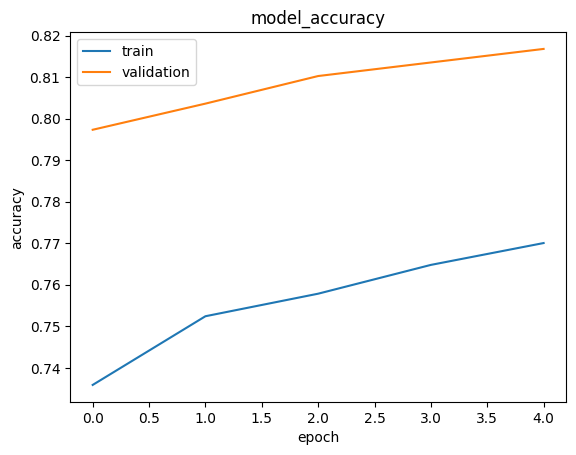

In [34]:
plot_hist(history)